# Advanced Risk Management – Assignment 1

**Deadline**:  February 20, 13.00h.

| |Name |Student number|Email|
|:-|:----|:-------------|:----|
|1.|  |        |     |
|2.|  |        |     |

****Hand in the following via Canvas****:
* Your notebook.
* A (printed) pdf version of your notebook. In Google Colab, this is most conveniently done in the Chrome browser, and then using the **`File` -> `Print`** menu option; you may have to print in landscape mode to make sure that everything appears in the pdf.

****Notes****:
* The assignment is part of the examination, so the usual rules regarding plagiarism and fraud apply.
* Before submitting your work, click on **`Runtime`-> `Restart and run all ...`** and verify that your notebook produces the desired results and does not error.

**Declaration of Originality**: We whose names are given under 1. and 2. above declare that these solutions are solely our own work, and that we have not made these solutions available to any other student.

## Introduction
The file `RV_data.xlsx` contains daily data (January 2000 – February 2020, or a sub-period), for a number of international stock market indices, on the open-to-close log-return R (measured as percentage) and the daily realized variance RV (obtained from 5-minute returns).
A list of the included indices is given on the website of the data provider, see
https://realized.oxford-man.ox.ac.uk/data/assets (in the Excel file, the leading '.' has been removed from the symbol; e.g. `FCHI` instead of `.FCHI`). In this assignment, you are asked to estimate, test and compare two GARCH models for one of the indices in terms of their in-sample fit and their out-of-sample forecast quality.

## Question 1: Load and display data
First, install and import the relevant libraries:

In [14]:
# !pip install arch             
import numpy as np
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf

# If you cannot import arch, then import the previous version as follows:
# !pip install arch==4.6.0 # this is an old version of 'arch' package, helps to avoid an error
# from arch import arch_model

In [15]:
# 2) Direcly read imported 'Excel file'
# Note that I use raw data: you already have adjusted data (scaled), so you don't need to define returns, scale them and scale RV; eveyrything is done for you!
df = pd.read_excel(r'C:\Users\Jinhyun\Documents\GitHub\Advanced-Risk-Management\Tutorial\Week 2\RV_data.xlsx')
# df['Date'] = df['Date'].str[0:10] # remove irrelevant parts of date string, this helps to get rid of the seconds in the data frame


Next, import the data and obtain the returns for one chosen index. Uncomment and adapt the lines necessary to mount the drive and change the path.

In [16]:
# Recall that there are two ways of downloading data:

# 1) 
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/My Drive/Colab Notebooks/ARM/Assignment1/'    # change path to your working directory
# os.chdir(path)


# df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d') # transform date strings to datetime 
# df = df.set_index(['Date'])  # set index of DataFrame to the date column (this allows you to refer to rows of your DataFrame using just time index, it is convenient)
# sel = df['Symbol']=='.AEX'   # Boolean array to select index;
                             # change 'ABC' to chosen index symbol, e.g., 'FCHI'
# Define returns   
# df['R'] = np.log(df['close_price']) - np.log((df['close_price']).shift(1)) # calculate close-to-close returns (not that in lab 1 we used different formula)
# df.dropna() # drop N/A entries

# Select particular returns and RV
# R = 100 * (df['R'].loc[sel])['2000-01-04':] # transform returns to percentages (recommended for GARCH package) and remove first row from returns 
# RV = 100**2 * (df['rv5'].loc[sel])['2000-01-04':] # transform realized variances as well

# Define new Data Frame: first column - return; second - RV
# df2 = pd.DataFrame({'R': R,'RV': RV}) # create DateFrame of transformed returns and realized variances


# Note on the adjustement for close-to-close return:
# 1) We compute r_t using closing prices, this means that r_t is return on an investment buying asset at the end of yesterday and selling at the end of today
# 2) However, assets (stocks, foreign exchange) are traded !during! the day. This means that high-frequency prices are available between 'open' and 'close'.
# 3) Availability of high-frequency prices implies that the realised variance (sum of squared high-frequency prices) only accounts for information between 'open' and 'close'
# Hence, it does not account for information between 'close' and 'open' (overnight information)
# 4) In other words, the realised variance (RV) is directly related to the volatility of open-to-close returns, but captures only a fraction of the volatility of close-to-close returns.
# 5) This means that we have to re-scale RV to account for these overnight news (close-to-open news), because once again, our returns are close-to-close!
# df2['RV'] = df2['RV'] / (df2['RV'].mean() / (df2['R']**2).mean()) # rescale RV to account for close-to-open news

In [17]:
R = df['R']
RV = df['RV']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.set_index(['Date'])
sel = df['Symbol']=='.AEX'

In [22]:
df

,Symbol,R,RV
Date,,,
2000-01-03,AEX,-0.034046,1.301702
2000-01-04,AEX,-3.360567,2.013057
2000-01-05,AEX,-0.167499,4.909661
2000-01-06,AEX,-1.313013,2.251396
2000-01-07,AEX,2.501328,1.384146
...,...,...,...
2020-02-04,STOXX50E,1.583697,0.388543
2020-02-05,STOXX50E,1.376502,0.617154
2020-02-06,STOXX50E,0.334701,0.350894


Display a line graph of the returns, and display the autocorrelation function of the returns and of the squared returns. Discuss whether you find the "stylized facts" mentioned in the textbook and slides of the course.

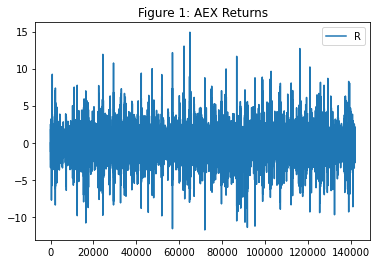

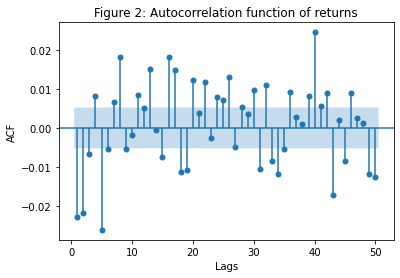

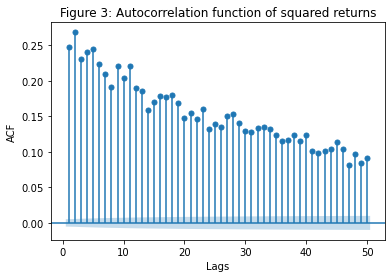

In [19]:
R.plot()
plt.title('Figure 1: AEX Returns')
plt.legend(['R'])
plt.show()
plot_acf(R, lags=np.arange(1,51))
plt.title('Figure 2: Autocorrelation function of returns')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()
plot_acf(R**2, lags=np.arange(1,51))
plt.title('Figure 3: Autocorrelation function of squared returns')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

Discussion of results:
* The returns in Figure 1 clearly display volatility clustering, which is confirmed by Figure 3 (autocorrelation function of squared returns).
* The mean return seems close to zero; all this is in agreement with the stylized facts.
* The autocorrelations in the returns are small (less than 0.05 in absolute value), but we do see some significant autocorrelations.

## Question 2: Fitting a symmetric GARCH model
Estimate and test a GARCH model for the returns, using only data over the sub-period January 2000 – December 2012. For this question, do **not** consider a GJR-GARCH model or any model with an asymmetric NIC (see next question), but focus on standard GARCH($p,q$) models. Display and discuss the estimation output, and test the model for the absence of volatility clustering in the standardized residuals (shocks) $\hat{z}_t$. If you try out various GARCH models, only report discuss the results on the final model.

Note: estimation over a sub-sample using the ARCH package can be done by specifying `last_obs =` in the `.fit` function; see https://arch.readthedocs.io.

In [20]:
split_date = dt.datetime(2013,1,2) # define last observation in your sub-sample

am1 = arch_model(R,p=1,o=0,q=1)
res1 = am1.fit(last_obs=split_date, disp='off')
print(res1.summary())

# Constract standardized residuals
z1 = res1.resid['2000-01-04':'2012-12-31'] # extract residuals from the model (varepsilon_t), extract only values from sub-sample (rest is NaN)
cond_vol1 = res1.conditional_volatility['2000-01-04':'2012-12-31'] # extract conditional volatility
z1_stand = z1/cond_vol1 # obtain standardized residuals

# Plot standardized residuals
z1_stand.plot()
plt.title('Figure 4: Standardized shocks GARCH(1,1)')
plt.legend(['z'])
plt.show()

# Diagnostic check (based on standardised residuals): since e_t (see presentation slides) are i.i.d. N(0,1), we should find no autocorrelation in \hat_e_t, \hat_e^2_t if the model is correctly specified
# Plot autocorrelation function of standardized residuals: to check whether some heteroscedasticity is still there (remaining volatility clustering)
plot_acf(z1_stand**2, lags=np.arange(1,51))
plt.title('Figure 5: Autocorrelation function of squared shocks, GARCH(1,1)')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

# alternative way of plotting standardized residuals + conditional volatility; could serve as a check for manual computation of standardised residuals
res1.plot()


ValueError: date_index must be a datetime64 array

Discussion of results:
* The estimation results show that $\hat{\alpha}$ and $\hat{\beta}$ are significantly different from zero, and have the typical values for financial data ($\hat{\alpha}\approx 0.1$, $\hat{\alpha}+\hat{\beta}$ close to but smaller than 1).
* The estimated mean return is significantly different from zero.
* The line graph of the shocks, and the autocorrelation function of $\hat{z}_t^2$ show very little remaining volatility clustering in $\hat{z}_t$, which suggests that GARCH(1,1) is sufficient.

## Question 3: Fitting an asymmetric GARCH model
(a) Extend the model you obtained above with one or more asymmetric terms (leading to a GJR-GARCH model), and estimate this second model using data over the same sub-period. Analogously to Question 2, display and discuss the estimation output, and test for volatility clustering in $\hat{z}_t$.

In [21]:
am2 = arch_model(R,p=1,o=1,q=1) # Note that change: asymmetric term is equal to 1 ('o=1')
res2 = am2.fit(last_obs=split_date, disp='off')
print(res2.summary())


z2 = res2.resid['2000-01-04':'2012-12-31']
cond_vol2 = res1.conditional_volatility['2000-01-04':'2012-12-31']
z2_stand = z2/cond_vol2

z2_stand.plot()
plt.title('Figure 6: Standardized shocks GJR-GARCH(1,1)')
plt.legend(['z'])
plt.show()

plot_acf(z2_stand**2, lags=np.arange(1,51))
plt.title('Figure 7: Autocorrelation function of squared shocks, GJR-GARCH(1,1)')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.show()

ValueError: date_index must be a datetime64 array

Discussion of results:
* We see that the estimated asymmetry parameter $\hat{\gamma}$ is positive and significantly different from zero.
* In this case $\hat{\alpha} = 0$, which implies that positive shocks have no effect on future volatility, only negative shocks.
* The stationarity condition is now $\alpha + \beta + \gamma/2 < 1$, which is satisfied by the estimates.
* The estimated mean return is now negative, and now not significantly different from 0.
* The shocks and the autocorrelation function of the squared shocks are almost the same as in the symmetric GARCH model.

(b) Carry out a likelihood ratio test for the symmetric model of Question 2 (the null hypothesis) against the asymmetric model of Question 3 (the alternative hypothesis). Obtain the p-value of the test from the `scipy.stats` library.

In [ ]:
LR = 2*(res2.loglikelihood - res1.loglikelihood)
pval = 1 - stats.chi2.cdf(LR,1)
print("Likelihood ratio statistic =", str.format('{0:.4f}', LR),
      "; p.value =", str.format('{0:.4f}', pval))

Discussion of results:
* The likelihood ratio statistic is much larger than the $\chi_1^2$ $5\%$ critical value (3.841), and indeed the p-value is essentially 0.
* So we reject the null hypothesis, the fit of the asymmetric GJR-GARCH model is significantly better than the symmetric GARCH model.

## Question 4: Comparing the out-of-sample fit
From the two models estimated above, obtain the out-of-sample (one-step-ahead) conditional variance predictions over the period January 2013 – February 2020. These are based on coefficient estimates from data until 2012, but they use the most recent returns $R_t$ to obtain the predictions for $\sigma_{t+1}^2$ in the period after 2012 (consult the ARCH package documentation for details).

(a) Make a new data-frame containing the two sets of variance predictions, as wel as the realized variance for the same index and over the same sub-period (January 2013 – February 2020). Make a plot of the two predicted volatility series (square root of the predicted variances) in one figure, and discuss similarities and differences.

In [ ]:
# Here you obtain forecast for \sigma^2_{t+1} for t running for indices in the out-of-sample period
sigma1sq = res1.forecast(horizon=1).variance.iloc[:,0] # one-step-ahead (horizon = 1) forecast of variance using GARCH model, 'iloc helps to choose particular strings, rows'
sigma2sq = res2.forecast(horizon=1).variance.iloc[:,0] # one-step-ahead (horizon = 1) forecast of variance using GJR-GARCH model

sigma1sq = sigma1sq['2013-01-01':'2020-02-10'] # Extract only values for out-of-sample period (because values for esimtation sub-sample are NaN, get rid of them)
sigma2sq = sigma2sq['2013-01-01':'2020-02-10'] # Extract onlye values for out-of-sample period

RV = RV['2013-01-01':'2020-02-10'] # Extract values of realised variance only for out-of-sample period
df2 = pd.DataFrame({'RV': RV, 'GARCH': sigma1sq, 'GJRGARCH': sigma2sq}) # Put RV, sigma^2_t from GARCH and sigma^2_t from GJR-GARCH into pandas DataFrame

plt.figure(figsize=(6, 4))
np.sqrt(sigma1sq).plot() # Note that we take sqrt of sigma^2_t, because we want to plot volatility (instead of variance)
np.sqrt(sigma2sq).plot() # Obtain volatility for GJR-GARCH model
plt.legend(['GARCH','GJR-GARCH'])
plt.title('Volatilities from GARCH and GJR-GARCH methods')
plt.ylabel('Volatility in %') # This is due to the scaling applied to returns (in % growth) 
plt.show()

Discussion of results:
* The two predicted volatility series have the same pattern in general, but differ in particular at the high volatility periods.
* Most often the GJR-GARCH predictions seem to have the highest peak (suggesting that these peaks were generated by negative returns).
* But at the end of 2016, GARCH model shows a peak in volatility which is not matched by the GJR-GARCH model (suggesting that this was generated by positive returns).

(b) Calculate the mean squared error of the two variance predictions (using the realized variance as the true $\sigma_{t+1}^2$), and discuss the result; which one of the two models gives the best predictions?

In [ ]:
# We compare our variance prediction (sigma^2_t) with the observed proxy for it, which is RV;
# This is because sigma^2_t itself is not observed, we have no realised series for it
MSE1 = ((RV-sigma1sq)**2).mean()
MSE2 = ((RV-sigma2sq)**2).mean()
print("MSE     GARCH = ", str.format('{0:.4f}', MSE1))
print("MSE GJR-GARCH = ", str.format('{0:.4f}', MSE2))

Discussion of results: The difference is not large (about 1.45%), but the GJR-GARCH has a slightly lower MSE, and hence gives the best predictions.

(c) As discussed in Sections 4.6.3 and 5.7 of the book, variance forecasts $\hat{\sigma}_{t+1}^2$ can be evaluated in the linear regression

$RV_{t+1} = b_0 + b_1\hat{\sigma}_{t+1}^2 + e_{t+1}$,

by testing the two restrictions $b_0=0, b_1=1$ (separately and jointly).
Estimate this regression twice: first, using the symmetric GARCH model prediction (Question 2), and next, using the asymmetric GARCH model prediction (Question 3) as explanatory variable. Report the estimation results and the outcome of the $F$-test for $b_0=0, b_1=1$ (use heteroskedasticity-robust standard errors). What do you conclude?

In [ ]:
# Recall that you constructed above the new pandas DataFrame (named 'df2') with three columns: RV, GARCH, GJRGARCH
# We refer to 'df2' to run two regressions above

# Regression for GARCH model
reg1 = smf.ols('RV ~ GARCH', data=df2)
resreg1 = reg1.fit(cov_type='HC1') # heteroscedasticity-robust standard errors
print(resreg1.summary2())
# F-test
ftest1 = resreg1.f_test("Intercept = 0, GARCH=1")
F1 = ftest1.fvalue[0][0]
p1 = ftest1.pvalue
print('F-test for b0=0, b1=1: F =', str.format('{0:.4f}', F1),'; p-value =', str.format('{0:.4f}', p1))
print('')

# Regression for GJR model
reg2 = smf.ols('RV ~ GJRGARCH', data=df2)
resreg2 = reg2.fit(cov_type='HC1')
print(resreg2.summary2())
# F-test
ftest2 = resreg2.f_test("Intercept = 0,GJRGARCH=1")
F2 = ftest2.fvalue[0][0]
p2 = ftest2.pvalue
print('F-test for b0=0, b1=1: F =', str.format('{0:.4f}', F2),'; p-value =', str.format('{0:.4f}', p2))


Discussion of results:
* What can you say about separate tests for b0=0 and b1=1? (Note that by default H0=0, hence for b1 you have to adjust z-statistic, or use the confidence interval). t-test does not rejct b0=0, what can you say about b1=1?
* In both regressions, the joint F-test does reject the null hypothesis. 
* The b1 coefficient for the GJR-GARCH predictions is quite far from 1, suggesting that the GJR-GARCH predictions are too variable.
* On the other hand the R-squared is a bit higher for the GJR-GARCH predictions.
* The overall conclusion is that both models seem to predict about equally well.